In [ ]:
import zipfile

with zipfile.ZipFile('/content/taxi_zones.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/taxi_zones')


In [ ]:
import geopandas as gpd
import pandas as pd


gdf = gpd.read_file('/content/taxi_zones/taxi_zones.shp')

# Then convert to WGS84 (GPS lat/lon)
gdf = gdf.to_crs(epsg=4326)

# Calculate centroids
gdf['latitude'] = gdf.geometry.centroid.y
gdf['longitude'] = gdf.geometry.centroid.x


# Now calculate true latitude and longitude
gdf['latitude'] = gdf.geometry.centroid.y
gdf['longitude'] = gdf.geometry.centroid.x

# Now re-run your column selection
zone_col = [col for col in gdf.columns if col.lower() == 'zone'][0]
borough_col = [col for col in gdf.columns if col.lower() == 'borough'][0]
zone_centroids = gdf[['LocationID', zone_col, borough_col, 'latitude', 'longitude']]
zone_centroids = zone_centroids.dropna(subset=['latitude', 'longitude'])
zone_centroids.columns = ['LocationID', 'Zone', 'Borough', 'latitude', 'longitude']
zone_centroids.head()


<ipython-input-5-80fd8f5397a3>:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['latitude'] = gdf.geometry.centroid.y
<ipython-input-5-80fd8f5397a3>:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['longitude'] = gdf.geometry.centroid.x
<ipython-input-5-80fd8f5397a3>:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['latitude'] = gdf.geometry.centroid.y
<ipython-input-5-80fd8f5397a3>:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this

,LocationID,Zone,Borough,latitude,longitude
0,1,Newark Airport,EWR,40.691831,-74.174000
1,2,Jamaica Bay,Queens,40.616745,-73.831299
2,3,Allerton/Pelham Gardens,Bronx,40.864474,-73.847422
3,4,Alphabet City,Manhattan,40.723752,-73.976968
4,5,Arden Heights,Staten Island,40.552659,-74.188484


In [ ]:
zone_centroids.to_csv('nyc_taxi_zone_centroids.csv', index=False)

In [ ]:
brooklyn_zones = zone_centroids[zone_centroids['Borough'].str.strip().str.lower() == 'brooklyn'].copy()
print("Number of Brooklyn zones:", brooklyn_zones.shape[0])
print("Sample zones:", brooklyn_zones['Zone'].unique()[:10])


Number of Brooklyn zones: 61
Sample zones: ['Bath Beach' 'Bay Ridge' 'Bedford' 'Bensonhurst East' 'Bensonhurst West'
 'Boerum Hill' 'Borough Park' 'Brighton Beach' 'Brooklyn Heights'
 'Brooklyn Navy Yard']


In [ ]:
import numpy as np

num_customers = 10
num_vehicles = 2
truck_capacity = 10

sampled_zones = brooklyn_zones.sample(num_customers + 1, random_state=42).reset_index(drop=True)
sampled_zones['location_id'] = sampled_zones.index

# 2. Generate feasible demands
demands = np.random.randint(1, truck_capacity + 1, size=num_customers)
while demands.sum() > num_vehicles * truck_capacity:
    demands = np.random.randint(1, truck_capacity + 1, size=num_customers)
sampled_zones['demand'] = [0] + demands.tolist()

# 3.feasible time windows (in minutes from midnight)
sampled_zones['time_window_start'] = 9 * 60     # 09:00 AM
sampled_zones['time_window_end']   = 18 * 60    # 06:00 PM
sampled_zones.loc[0, ['time_window_start', 'time_window_end']] = [8*60, 18*60]  # Depot: 08:00–18:00

# 4. Build final locations DataFrame
locations = sampled_zones[['location_id', 'latitude', 'longitude', 'demand', 'time_window_start', 'time_window_end']]
print(locations)


    location_id   latitude  longitude  demand  time_window_start  \
0             0  40.604273 -74.007488       0                480   
1             1  40.685634 -73.986114       2                540   
2             2  40.617315 -73.970326       1                540   
3             3  40.637900 -73.960968       2                540   
4             4  40.638037 -73.899735       1                540   
5             5  40.688168 -73.931888       1                540   
6             6  40.673513 -73.990647       3                540   
7             7  40.677635 -73.967587       1                540   
8             8  40.694994 -73.922240       4                540   
9             9  40.604914 -73.948136       1                540   
10           10  40.690787 -73.974882       1                540   

    time_window_end  
0              1080  
1              1080  
2              1080  
3              1080  
4              1080  
5              1080  
6              1080  
7      

In [ ]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lat2 = np.radians(lat1), np.radians(lat2)
    dlat = lat2[:, None] - lat1
    dlon = np.radians(lon2)[:, None] - np.radians(lon1)
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2[:, None]) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

latitudes = locations['latitude'].values
longitudes = locations['longitude'].values
distance_matrix = haversine(latitudes, longitudes, latitudes, longitudes)


In [ ]:
!pip install ortools


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.6/27.6 MB 80.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.1/321.1 kB 30.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 6.31.1 which is incompatible.
google-ai-generativelanguage 0.6.15 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.2, but you have protobuf 6.31.1 w

In [ ]:
from ortools.constraint_solver import pywrapcp, routing_enums_pb2

num_locations = len(locations)
depot = 0

manager = pywrapcp.RoutingIndexManager(num_locations, num_vehicles, depot)
routing = pywrapcp.RoutingModel(manager)

# Distance callback (meters, as before)
def distance_callback(from_index, to_index):
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return int(distance_matrix[from_node, to_node] * 1000)
transit_callback_index = routing.RegisterTransitCallback(distance_callback)
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Capacity constraint (as before)
demands = locations['demand'].tolist()
def demand_callback(from_index):
    from_node = manager.IndexToNode(from_index)
    return demands[from_node]
demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
routing.AddDimensionWithVehicleCapacity(
    demand_callback_index, 0, [truck_capacity]*num_vehicles, True, 'Capacity'
)

# Add Time Window Constraints ---
service_time = 5  # minutes at each stop

def time_callback(from_index, to_index):
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    # 40 km/h = 0.67 km/min
    travel_time = distance_matrix[from_node, to_node] / 0.67
    return int(travel_time + service_time)
time_callback_index = routing.RegisterTransitCallback(time_callback)
routing.AddDimension(
    time_callback_index,
    60,        # slack (waiting time allowed at stops)
    12*60,     # max route time (12 hours)
    False,
    'Time'
)
time_dimension = routing.GetDimensionOrDie('Time')

# Assign time windows from your locations DataFrame
time_windows = list(zip(locations['time_window_start'], locations['time_window_end']))
for location_idx, (open_time, close_time) in enumerate(time_windows):
    index = manager.NodeToIndex(location_idx)
    time_dimension.CumulVar(index).SetRange(int(open_time), int(close_time))
for vehicle_id in range(num_vehicles):
    index = routing.Start(vehicle_id)
    time_dimension.CumulVar(index).SetRange(8*60, 18*60)

# --- End Time Window setup ---

search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.time_limit.seconds = 60
search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
search_parameters.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH

solution = routing.SolveWithParameters(search_parameters)

def min2str(m): return f"{int(m//60):02}:{int(m%60):02}"
def print_solution(manager, routing, solution):
    if not solution:
        print("No solution found.")
        return
    total_distance = 0
    for vehicle_id in range(num_vehicles):
        index = routing.Start(vehicle_id)
        plan_output = f"Route for truck {vehicle_id}:\n"
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += demands[node_index]
            time_var = routing.GetDimensionOrDie('Time').CumulVar(index)
            plan_output += (
                f" {node_index} (load {route_load}) "
                f"[{min2str(solution.Min(time_var))}-{min2str(solution.Max(time_var))}] ->"
            )
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id)
        plan_output += f" {manager.IndexToNode(index)}\n"
        plan_output += f"  Distance: {route_distance/1000:.2f} km\n"
        print(plan_output)
        total_distance += route_distance
    print(f"Total distance: {total_distance/1000:.2f} km")

print_solution(manager, routing, solution)


Route for truck 0:
 0 (load 0) [08:00-10:43] -> 2 (load 1) [09:00-10:53] -> 3 (load 3) [09:08-11:01] -> 5 (load 4) [09:22-11:15] -> 8 (load 8) [09:28-11:21] -> 4 (load 9) [09:42-11:35] -> 9 (load 10) [09:55-11:48] -> 0
  Distance: 30.21 km

Route for truck 1:
 0 (load 0) [08:00-11:06] -> 6 (load 3) [09:00-11:22] -> 1 (load 5) [09:07-11:29] -> 10 (load 6) [09:13-11:35] -> 7 (load 7) [09:20-11:42] -> 0
  Distance: 20.75 km

Total distance: 50.96 km


Visualization

In [ ]:
fail_count = 0
for idx, row in locations.iterrows():
    try:
        node, dist = ox.nearest_nodes(graph, row['longitude'], row['latitude'], return_dist=True)
        print(f"Stop {idx}: node {node}, distance {dist:.1f} meters")
    except Exception as e:
        print(f"Stop {idx}: FAILED ({row['latitude']}, {row['longitude']}) - {e}")
        fail_count += 1
if fail_count == 0:
    print("All stops successfully mapped to the Brooklyn road network!")
else:
    print(f"{fail_count} stops could not be mapped to a road.")


Stop 0: FAILED (40.60427284003079, -74.00748815801174) - name 'ox' is not defined
Stop 1: FAILED (40.6856337413206, -73.98611382213656) - name 'ox' is not defined
Stop 2: FAILED (40.61731493715171, -73.97032580128304) - name 'ox' is not defined
Stop 3: FAILED (40.63790012347375, -73.96096824906371) - name 'ox' is not defined
Stop 4: FAILED (40.63803713911706, -73.89973495669396) - name 'ox' is not defined
Stop 5: FAILED (40.68816818695491, -73.93188826440705) - name 'ox' is not defined
Stop 6: FAILED (40.673512796860756, -73.9906472736312) - name 'ox' is not defined
Stop 7: FAILED (40.67763538934729, -73.96758681222951) - name 'ox' is not defined
Stop 8: FAILED (40.694994318442106, -73.92224002165717) - name 'ox' is not defined
Stop 9: FAILED (40.6049135955638, -73.94813559494118) - name 'ox' is not defined
Stop 10: FAILED (40.69078679421089, -73.97488208618893) - name 'ox' is not defined
11 stops could not be mapped to a road.


In [ ]:
!pip install osmnx


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 3.3 MB/s eta 0:00:00


In [ ]:
import osmnx as ox

# Download Brooklyn's drivable road network
graph = ox.graph_from_place('Brooklyn, New York City, New York, USA', network_type='drive')

# Project the graph for plotting
graph_proj = ox.project_graph(graph)

# Now print its CRS (Coordinate Reference System)
print(graph_proj.graph['crs'])
print(graph_proj.graph['crs'])


EPSG:32618
EPSG:32618


In [ ]:
import geopandas as gpd
from shapely.geometry import Point

# 1. Create GeoDataFrame from your locations DataFrame
gdf_points = gpd.GeoDataFrame(
    locations,
    geometry=[Point(xy) for xy in zip(locations['longitude'], locations['latitude'])],
    crs='EPSG:4326'  # Your stops are in lat/lon
)

# 2. Project to the road graph's CRS
gdf_points_proj = gdf_points.to_crs(graph_proj.graph['crs'])


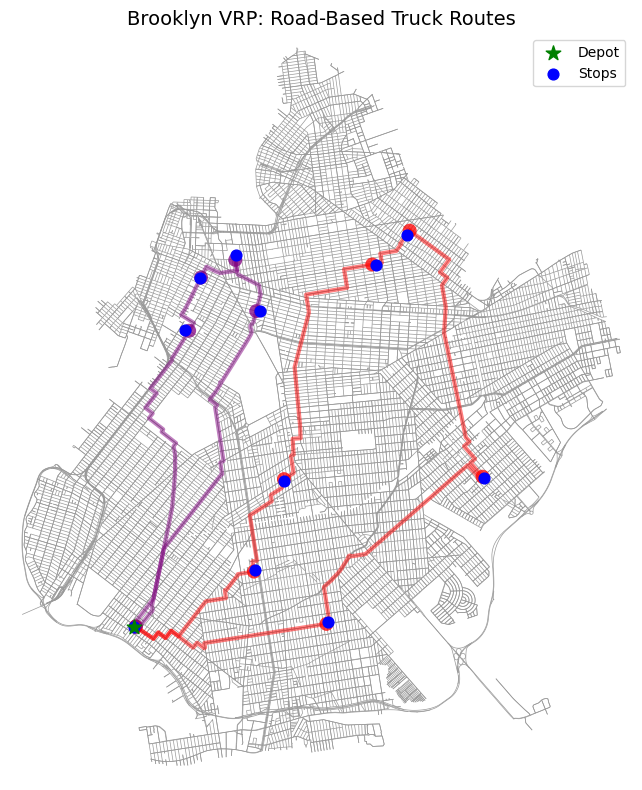

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

fig, ax = ox.plot_graph(graph_proj, show=False, close=False, bgcolor='white', node_size=0, edge_linewidth=0.5)

route_colors = ['red', 'purple', 'orange', 'darkblue', 'black', 'cadetblue', 'darkgreen']
any_route = False

for vehicle_id in range(num_vehicles):
    index = routing.Start(vehicle_id)
    route = []
    while not routing.IsEnd(index):
        node_index = manager.IndexToNode(index)
        route.append(node_index)
        index = solution.Value(routing.NextVar(index))
    route.append(manager.IndexToNode(index))  # Return to depot

    if len(route) > 2:
        # Use original longitude, latitude for nearest_nodes
        route_coords = [(locations.loc[n, 'longitude'], locations.loc[n, 'latitude']) for n in route]
        for i in range(len(route_coords) - 1):
            try:
                # Use unprojected coordinates to snap to OSMNX nodes
                orig = ox.nearest_nodes(graph, route_coords[i][0], route_coords[i][1])
                dest = ox.nearest_nodes(graph, route_coords[i+1][0], route_coords[i+1][1])
                path = nx.shortest_path(graph, orig, dest, weight='length')
                ox.plot_graph_route(graph_proj, path, ax=ax, route_color=route_colors[vehicle_id % len(route_colors)],
                                    route_linewidth=3, orig_dest_node_size=0, show=False, close=False)
                any_route = True
            except Exception as e:
                print(f"Truck {vehicle_id}, leg {i}: Could not plot road route: {e}")

ax.scatter(gdf_points_proj.geometry.x.iloc[0], gdf_points_proj.geometry.y.iloc[0], c='green', s=120, marker='*', label='Depot', zorder=20)
ax.scatter(gdf_points_proj.geometry.x, gdf_points_proj.geometry.y, c='blue', s=60, label='Stops', zorder=15)

ax.set_title("Brooklyn VRP: Road-Based Truck Routes", fontsize=14)
ax.legend()
plt.tight_layout()
plt.savefig('brooklyn_vrp_roads.png', dpi=300)
plt.show()

if not any_route:
    print("No truck routes could be plotted on the Brooklyn street network! (But all stops are shown.)")
